In [4]:
import os
import matplotlib.pyplot as plt
from OA_utils.OAPreprocessingScripts import *
from OA_utils.OpenSimScripts import *
from OA_utils.data_utils import interp_segments, ad2float
import pickle
import numpy as np

In [5]:
root_dir = '/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/'
with open(root_dir + 'all_segs.pkl', 'rb') as f:
    all_segs = pickle.load(f)
print(all_segs)

{'OA1': {'OA1_80_1': {'left': [(1.2885, 2.0735)], 'right': [(0.6945, 1.475), (1.886, 2.696)]}, 'OA1_80_2': {'left': [(1.207, 2.011)], 'right': [(0.6065, 1.4145), (1.824, 2.6345)]}, 'OA1_80_3': {'left': [(1.151, 1.9685)], 'right': [(0.543, 1.357), (1.778, 2.577)]}, 'OA1_80_4': {'left': [(1.232, 2.0545)], 'right': [(0.624, 1.433), (1.8555, 2.689)]}, 'OA1_80_5': {'left': [(1.0405, 1.837)], 'right': [(0.4395, 1.2235), (1.652, 2.4615)]}, 'OA1_100_1': {'left': [(0.912, 1.6125)], 'right': [(0.37, 1.072), (1.4565, 2.1605)]}, 'OA1_100_2': {'left': [(1.0515, 1.741)], 'right': [(0.5325, 1.214), (1.5905, 2.278)]}, 'OA1_100_3': {'left': [(0.978, 1.6435)], 'right': [(0.476, 1.1395), (1.502, 2.178)]}, 'OA1_100_4': {'left': [(0.551, 1.1595), (1.5375, 2.1985)], 'right': [(1.0135, 1.698)]}, 'OA1_100_5': {'left': [(0.8995, 1.5655)], 'right': [(0.385, 1.061), (1.418, 2.1145)]}, 'OA1_120_1': {'left': [(0.9025, 1.513)], 'right': [(0.409, 1.0285)]}, 'OA1_120_2': {'left': [(0.7965, 1.4055)], 'right': [(0.347,

# Batch Plotting Inverse Kinematics Segments

In [110]:
def ik_data_to_segs(
    angles,
    seg_times,
    problem_trials,
    ik_data_dir,
    ik_suffix="_ik_filtered.mot",
):

    compiled_segs = {}

    # base angles in-order, allow both suffixed and unsuffixed inputs
    base_angles = []
    seen = set()
    for a in angles:
        b = a[:-2] if a.endswith(("_r", "_l")) else a
        if b not in seen:
            base_angles.append(b)
            seen.add(b)

    def load_ik_columns(storage, base_angles, side_suffix):
        time_col = osim.ArrayDouble()
        storage.getTimeColumn(time_col)
        t = ad2float(time_col)

        data = {}
        UNSUFFIXED = {
        "pelvis_tilt","pelvis_list","pelvis_rotation",
        "pelvis_tx","pelvis_ty","pelvis_tz",
        "lumbar_extension","lumbar_bending","lumbar_rotation"
    }

        for a in base_angles:
            col = osim.ArrayDouble()
            if a in UNSUFFIXED:
                storage.getDataColumn(a, col)
            else:
                storage.getDataColumn(f"{a}_{side_suffix}", col)
            data[a] = ad2float(col)

        return t, data

    problematic_segs = []

    for subject, trials in seg_times.items():
        compiled_segs[subject] = {a: [] for a in base_angles}

        for trial_name, seg_dict in trials.items():
            if trial_name in problem_trials:
                continue

            ik_path = os.path.join(ik_data_dir, f"{trial_name}{ik_suffix}")
            ik_storage = osim.Storage(ik_path)

            time, ik_r = load_ik_columns(ik_storage, base_angles, "r")
            _,    ik_l = load_ik_columns(ik_storage, base_angles, "l")

            for side, seg_list in seg_dict.items():
                side = side.lower()
                if side not in ("right", "left"):
                    continue

                ik_data = ik_r if side == "right" else ik_l

                for (s, e) in seg_list:
                    mask = (time >= s) & (time <= e)
                    if not mask.any():
                        continue
                    # ankle_seg = ik_data['ankle_angle'][mask]
                    # ankle_idx_75 = int(len(ankle_seg) * 0.75)
                    # if ankle_seg[ankle_idx_75] < -5:
                    #     problematic_segs.append({
                    #         'subject': trial_name,
                    #         'side': side,
                    #         'start_time': s,
                    #         'end_time':float(e)
                    #     })
                    #     continue
                    
                    for a in base_angles:
                        compiled_segs[subject][a].append(ik_data[a][mask])

    return compiled_segs, problematic_segs

In [117]:
angles = [
"time",
    "pelvis_tilt",
    "pelvis_list",
    "pelvis_rotation",
    "pelvis_tx",
    "pelvis_ty",
    "pelvis_tz",
    "hip_flexion_r",
    "hip_adduction_r",
    "hip_rotation_r",
    "knee_angle_r",
    "knee_angle_r_beta",
    "ankle_angle_r",
    "subtalar_angle_r",
    "mtp_angle_r",
    "hip_flexion_l",
    "hip_adduction_l",
    "hip_rotation_l",
    "knee_angle_l",
    "knee_angle_l_beta",
    "ankle_angle_l",
    "mtp_angle_l"
]

ik_segs, ik_problem = ik_data_to_segs(
    angles=angles,
    seg_times=all_segs,
    problem_trials=[],
    ik_data_dir="/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/IK/filtered"
)

[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/IK/filtered/OA1_80_1_ik_filtered.mot (nr=291 nc=26)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/IK/filtered/OA1_80_2_ik_filtered.mot (nr=286 nc=26)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/IK/filtered/OA1_80_3_ik_filtered.mot (nr=286 nc=26)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/IK/filtered/OA1_80_4_ik_filtered.mot (nr=291 nc=26)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/IK/filtered/OA1_80_5_ik_filtered.mot (nr=273 nc=26)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/IK/filtered/OA1_100_1_ik_filtered.mot (nr=225 nc=26)
[info] Storage: read data file = /Users/briankeller

In [118]:
for seg in ik_problem:
    trial = seg.get('subject')
    time = seg.get('start_time')
    print(f'Trial:{trial}, start time:{time}')

In [119]:
n_interp_points = 100
ik_resampled = {}
time_resampled = None

for subj, subj_data in ik_segs.items():
    ik_resampled[subj] = {}
    for key, seg_list in subj_data.items():
        if len(seg_list) == 0:
            ik_resampled[subj][key] = []
            continue

        resampled, t = interp_segments(seg_list, n_interp_points)
        ik_resampled[subj][key] = resampled

        # grab time_resampled once (they should all be identical if interp_segments is consistent)
        if time_resampled is None:
            time_resampled = t

# store once at the end
ik_resampled["time_resampled"] = time_resampled

def get_all_segments(resampled_segs, key):
    """
    Collects all resampled segments for a given signal across all subjects.
    """
    all_segs = []
    for subj, data in resampled_segs.items():
        if subj == "time_resampled":
            continue
        if key in data:
            all_segs.extend(data[key])
    return np.array(all_segs)

In [ ]:
ik_keys = [
    "pelvis_tilt",
    "pelvis_list",
    "pelvis_rotation",
    "pelvis_tx",
    "pelvis_ty",
    "pelvis_tz",
    "hip_flexion",
    "hip_adduction",
    "hip_rotation",
    "knee_angle",
    "ankle_angle",
    "subtalar_angle",
    "mtp_angle"
]

# compile across subjects ONCE (fast + consistent)
resampled_angles = {k: get_all_segments(ik_resampled, k) for k in ik_keys}
no_convert = {"pelvis_tx", "pelvis_ty", "pelvis_tz", "time"}

# fix time axis once (handles (T,) or (N,T))
t = np.asarray(ik_resampled["time_resampled"])
time_axis = t[0] if t.ndim == 2 else t   # (T,)

In [121]:
def plot_ik_grid_compiled(
    resampled_angles,
    time_axis,
    angle_keys,
    nrows=5,
    ncols=3,
    figsize=(15, 10),
    alpha=0.25,
    linewidth=1.5,
    plot_mean=True,
    mean_linewidth=3,
):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    x = time_axis * 100  # percent stance, (T,)

    for i, ax in enumerate(axes):
        if i >= len(angle_keys):
            ax.axis("off")
            continue

        key = angle_keys[i]
        segments = resampled_angles.get(key, None)
        if segments is None or len(segments) == 0:
            ax.set_title(key.replace("_", " ").title(), fontsize=14)
            ax.text(0.5, 0.5, "No segments", ha="center", va="center", transform=ax.transAxes)
            ax.grid(True, alpha=0.3)
            continue

        # segments should be (N,T) if get_all_segments returns np.array
        for seg in segments:
            ax.plot(x, seg, alpha=alpha, linewidth=linewidth)

        if plot_mean:
            Y = np.asarray(segments)
            if Y.ndim == 2:
                ax.plot(x, Y.mean(axis=0), linewidth=mean_linewidth)

        if i >= (nrows - 1) * ncols:
            ax.set_xlabel("Percent Normalized Stance", fontsize=12)
        if i % ncols == 0:
            ax.set_ylabel("Value", fontsize=12)

        ax.set_title(key.replace("_", " ").title(), fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)

    plt.tight_layout()

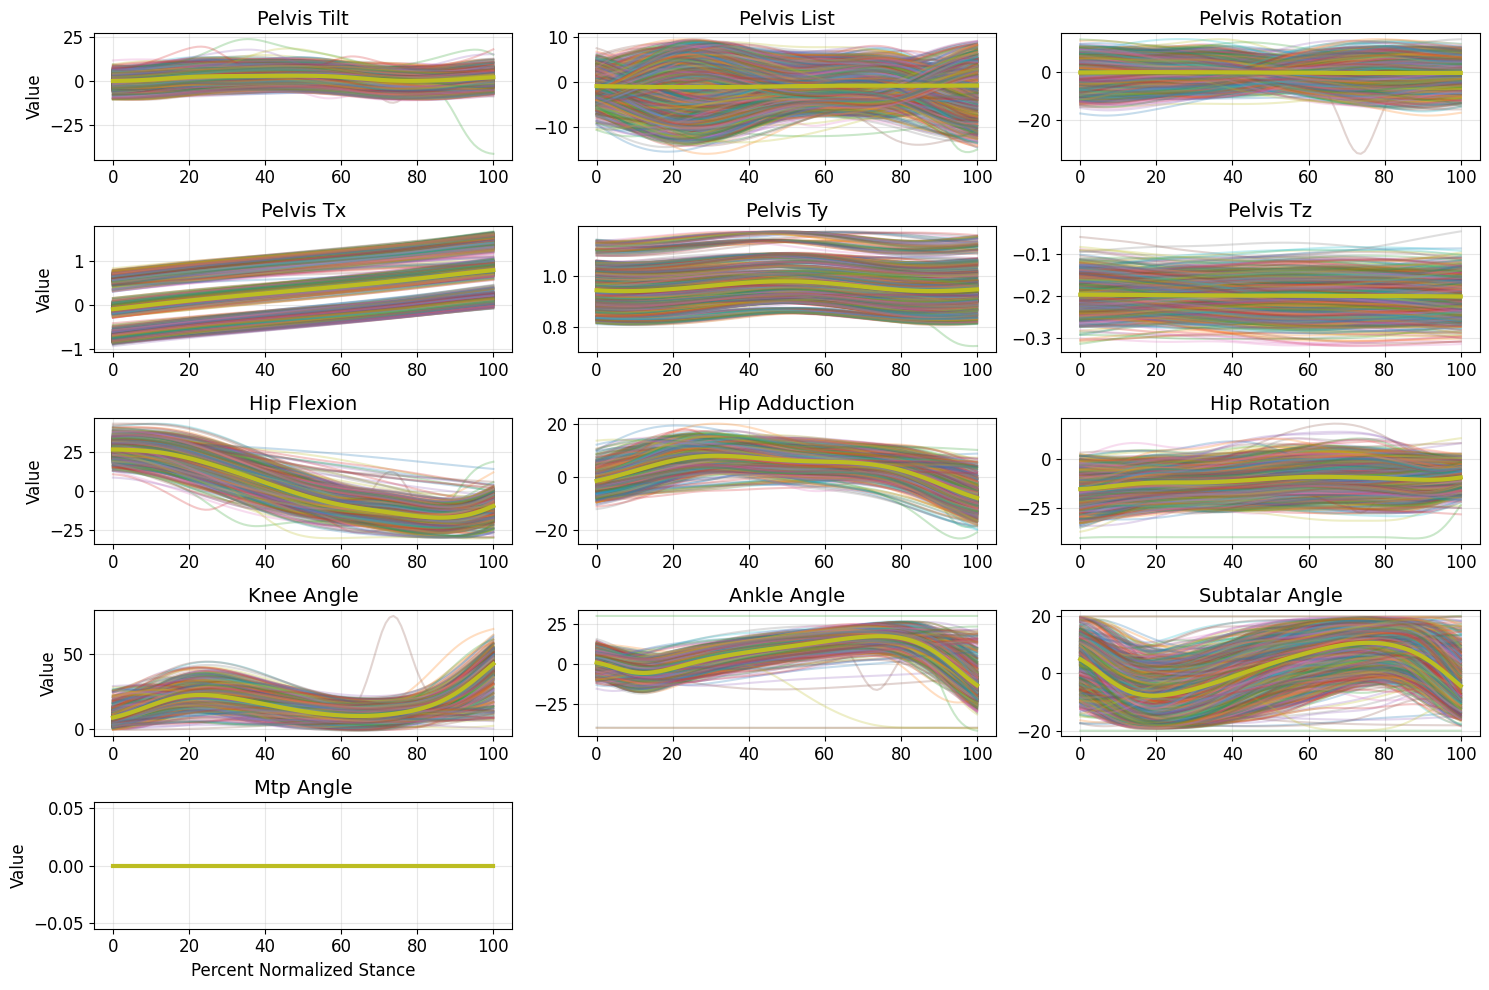

In [122]:
plot_ik_grid_compiled(resampled_angles, time_axis, ik_keys, nrows=5, ncols=3)

# Batch Plot Inverse Dynamics

In [123]:
def id_data_to_segs(
    measures,
    seg_times,
    problem_trials,
    id_data_dir,
    id_suffix="_id.sto",   # adjust to your actual filename pattern
):
    compiled_segs = {}

    # base measures in-order (drop _r/_l before _moment/_force if present)
    base_measures = []
    seen = set()
    for m in measures:
        if m.endswith(("_r_moment", "_l_moment")):
            b = m.replace("_r_moment", "").replace("_l_moment", "") + "_moment"
        elif m.endswith(("_r_force", "_l_force")):
            b = m.replace("_r_force", "").replace("_l_force", "") + "_force"
        else:
            b = m  # pelvis/lumbar already unsuffixed

        if b not in seen:
            base_measures.append(b)
            seen.add(b)

    # which columns are unsuffixed in the file
    UNSUFFIXED = {
        "pelvis_tilt_moment", "pelvis_list_moment", "pelvis_rotation_moment",
        "pelvis_tx_force", "pelvis_ty_force", "pelvis_tz_force",
        "lumbar_extension_moment", "lumbar_bending_moment", "lumbar_rotation_moment",
    }

    def load_id_columns(storage, base_measures, side_suffix):
        time_col = osim.ArrayDouble()
        storage.getTimeColumn(time_col)
        t = ad2float(time_col)

        data = {}
        for b in base_measures:
            col = osim.ArrayDouble()

            if b in UNSUFFIXED:
                storage.getDataColumn(b, col)
            else:
                # b looks like "hip_flexion_moment" or "knee_angle_force"
                # file columns look like "hip_flexion_r_moment"
                if b.endswith("_moment"):
                    name = b.replace("_moment", f"_{side_suffix}_moment")
                elif b.endswith("_force"):
                    name = b.replace("_force", f"_{side_suffix}_force")
                else:
                    name = f"{b}_{side_suffix}"  # fallback (shouldn't really happen)
                storage.getDataColumn(name, col)

            data[b] = ad2float(col)

        return t, data

    problematic_segs = []

    for subject, trials in seg_times.items():
        compiled_segs[subject] = {b: [] for b in base_measures}

        for trial_name, seg_dict in trials.items():
            if trial_name in problem_trials:
                continue

            id_path = os.path.join(id_data_dir, f"{trial_name}{id_suffix}")
            id_storage = osim.Storage(id_path)

            time, id_r = load_id_columns(id_storage, base_measures, "r")
            _,    id_l = load_id_columns(id_storage, base_measures, "l")

            for side, seg_list in seg_dict.items():
                side = side.lower()
                if side not in ("right", "left"):
                    continue

                id_data = id_r if side == "right" else id_l

                for (s, e) in seg_list:
                    mask = (time >= s) & (time <= e)
                    if not mask.any():
                        continue

                    for b in base_measures:
                        compiled_segs[subject][b].append(id_data[b][mask])

    return compiled_segs, problematic_segs

In [124]:
id_measures = [
    "pelvis_tilt_moment","pelvis_list_moment","pelvis_rotation_moment",
    "pelvis_tx_force","pelvis_ty_force","pelvis_tz_force",
    "hip_flexion_r_moment","hip_adduction_r_moment","hip_rotation_r_moment",
    "hip_flexion_l_moment","hip_adduction_l_moment","hip_rotation_l_moment",
    "lumbar_extension_moment","lumbar_bending_moment","lumbar_rotation_moment",
    "knee_angle_r_moment","knee_angle_r_beta_force",
    "knee_angle_l_moment","knee_angle_l_beta_force",
    "ankle_angle_r_moment","ankle_angle_l_moment",
    "subtalar_angle_r_moment","subtalar_angle_l_moment",
    "mtp_angle_r_moment","mtp_angle_l_moment"
]

id_segs, id_problem = id_data_to_segs(
    measures=id_measures,
    seg_times=all_segs,
    problem_trials=[],
    id_data_dir="/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/ID/filtered",  # example
    id_suffix="_id_filtered.mot" 
)

[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/ID/filtered/OA1_80_1_id_filtered.mot (nr=301 nc=26)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/ID/filtered/OA1_80_2_id_filtered.mot (nr=301 nc=26)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/ID/filtered/OA1_80_3_id_filtered.mot (nr=301 nc=26)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/ID/filtered/OA1_80_4_id_filtered.mot (nr=301 nc=26)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/ID/filtered/OA1_80_5_id_filtered.mot (nr=300 nc=26)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/ID/filtered/OA1_100_1_id_filtered.mot (nr=300 nc=26)
[info] Storage: read data file = /Users/briankeller

In [128]:
n_interp_points = 100
id_resampled = {}
time_resampled = None

for subj, subj_data in id_segs.items():
    id_resampled[subj] = {}
    for key, seg_list in subj_data.items():
        if len(seg_list) == 0:
            id_resampled[subj][key] = []
            continue

        resampled, t = interp_segments(seg_list, n_interp_points)
        id_resampled[subj][key] = resampled

        if time_resampled is None:
            t = np.asarray(t)
            time_resampled = t[0] if t.ndim == 2 else t  # force (T,)

id_resampled["time_resampled"] = time_resampled

In [129]:
id_keys = [
    "hip_flexion_moment", "hip_adduction_moment", "hip_rotation_moment",
    "knee_angle_moment", "ankle_angle_moment",
    "subtalar_angle_moment", "mtp_angle_moment",
    "pelvis_tx_force", "pelvis_ty_force", "pelvis_tz_force",
    "pelvis_tilt_moment", "pelvis_list_moment", "pelvis_rotation_moment",
]

id_compiled = {k: get_all_segments(id_resampled, k) for k in id_keys}
time_axis = id_resampled["time_resampled"]  # (T,)

In [130]:
def plot_id_grid_compiled(
    id_compiled,
    time_axis,
    keys,
    nrows=4,
    ncols=3,
    figsize=(16, 10),
    alpha=0.25,
    linewidth=1.5,
    plot_mean=True,
    mean_linewidth=3,
):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    x = np.asarray(time_axis).reshape(-1) * 100  # percent stance

    for i, ax in enumerate(axes):
        if i >= len(keys):
            ax.axis("off")
            continue

        k = keys[i]
        segs = id_compiled.get(k, None)

        if segs is None or len(segs) == 0:
            ax.set_title(k.replace("_", " ").title(), fontsize=12)
            ax.text(0.5, 0.5, "No segments", ha="center", va="center", transform=ax.transAxes)
            ax.grid(True, alpha=0.3)
            continue

        for seg in segs:
            ax.plot(x, seg, alpha=alpha, linewidth=linewidth)

        if plot_mean:
            Y = np.asarray(segs)
            if Y.ndim == 2:
                ax.plot(x, Y.mean(axis=0), linewidth=mean_linewidth)

        if i >= (nrows - 1) * ncols:
            ax.set_xlabel("Percent Normalized Stance", fontsize=11)
        if i % ncols == 0:
            ax.set_ylabel("Moment / Force", fontsize=11)

        ax.set_title(k.replace("_", " ").title(), fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis="x", labelsize=10)
        ax.tick_params(axis="y", labelsize=10)

    plt.tight_layout()
    plt.show()

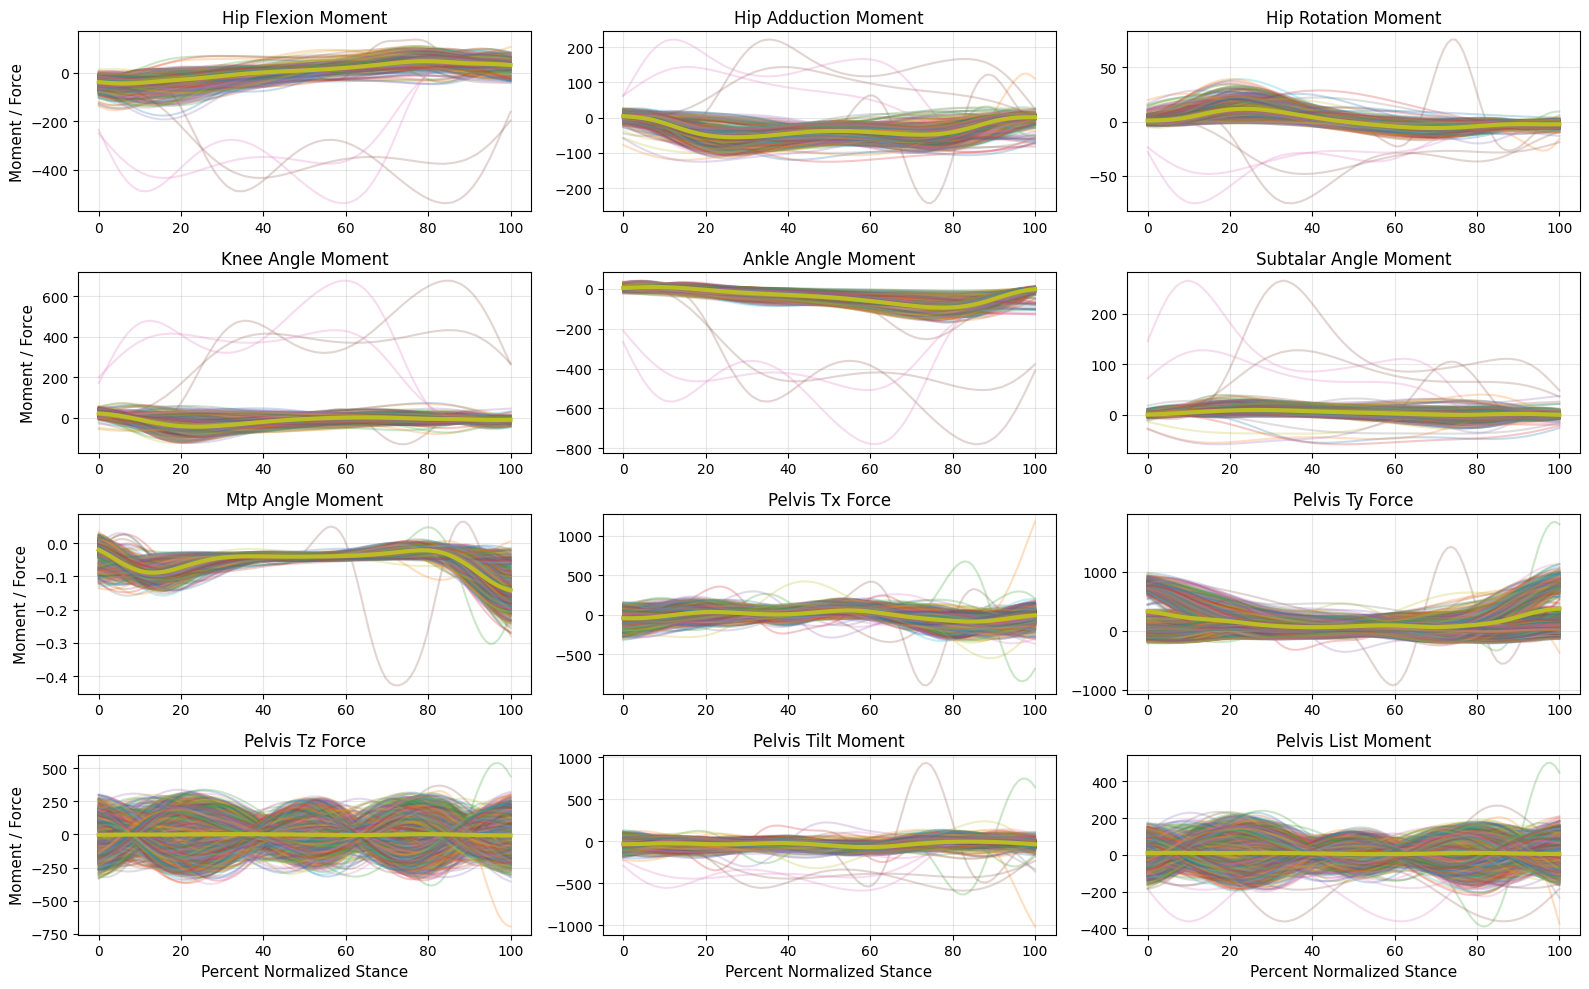

In [131]:
plot_id_grid_compiled(id_compiled, time_axis, id_keys, nrows=4, ncols=3)

In [132]:
print(id_compiled.keys())

dict_keys(['hip_flexion_moment', 'hip_adduction_moment', 'hip_rotation_moment', 'knee_angle_moment', 'ankle_angle_moment', 'subtalar_angle_moment', 'mtp_angle_moment', 'pelvis_tx_force', 'pelvis_ty_force', 'pelvis_tz_force', 'pelvis_tilt_moment', 'pelvis_list_moment', 'pelvis_rotation_moment'])


In [133]:
print(np.mean(id_compiled['pelvis_ty_force']))

148.41992831130446


# Batch Plot Activations

In [134]:
def activations_to_segs(muscles, seg_times, problem_trials, states_dir, states_filename="results_states.sto"):
    """
    muscles: list like ["tibant_r", "tibant_l", ...] or your full muscles list
    states_dir: base dir that contains trial subfolders like muscle_force_dir did
               e.g. .../Results/SO
    reads: <states_dir>/<trial_name>/<states_filename>
    extracts: /forceset/<muscle_side>/activation
    stores under base names (no _r/_l) just like your other segment dicts
    """
    compiled_segs = {}

    # base muscles, in sorted unique order
    base_muscles = sorted({m[:-2] for m in muscles if m.endswith(("_r", "_l"))})

    def load_activation_columns(storage, base_muscles, side_suffix):
        time_col = osim.ArrayDouble()
        storage.getTimeColumn(time_col)
        t = ad2float(time_col)

        data = {}
        for m in base_muscles:
            col = osim.ArrayDouble()
            # states file uses path-style names:
            storage.getDataColumn(f"/forceset/{m}_{side_suffix}/activation", col)
            data[m] = ad2float(col)
        return t, data

    problematic_segs = []

    for subject, trials in seg_times.items():
        compiled_segs[subject] = {m: [] for m in base_muscles}

        for trial_name, seg_dict in trials.items():
            if trial_name in problem_trials:
                continue

            states_path = os.path.join(states_dir, trial_name, states_filename)
            states_storage = osim.Storage(states_path)

            time, act_r = load_activation_columns(states_storage, base_muscles, "r")
            _,    act_l = load_activation_columns(states_storage, base_muscles, "l")

            for side, seg_list in seg_dict.items():
                side = side.lower()
                if side not in ("right", "left"):
                    continue

                act_data = act_r if side == "right" else act_l

                for (s, e) in seg_list:
                    mask = (time >= s) & (time <= e)
                    if not mask.any():
                        continue

                    for m in base_muscles:
                        compiled_segs[subject][m].append(act_data[m][mask])

    return compiled_segs, problematic_segs

In [135]:
muscles = [
    "addbrev_r", "addlong_r", "addmagDist_r", "addmagIsch_r", "addmagMid_r", "addmagProx_r",
    "bflh_r", "bfsh_r", "edl_r", "ehl_r", "fdl_r", "fhl_r", "gaslat_r", "gasmed_r",
    "glmax1_r", "glmax2_r", "glmax3_r", "glmed1_r", "glmed2_r", "glmed3_r",
    "glmin1_r", "glmin2_r", "glmin3_r", "grac_r", "iliacus_r", "perbrev_r", "perlong_r",
    "piri_r", "psoas_r", "recfem_r", "sart_r", "semimem_r", "semiten_r", "soleus_r", "tfl_r",
    "tibant_r", "tibpost_r", "vasint_r", "vaslat_r", "vasmed_r",

    "addbrev_l", "addlong_l", "addmagDist_l", "addmagIsch_l", "addmagMid_l", "addmagProx_l",
    "bflh_l", "bfsh_l", "edl_l", "ehl_l", "fdl_l", "fhl_l", "gaslat_l", "gasmed_l",
    "glmax1_l", "glmax2_l", "glmax3_l", "glmed1_l", "glmed2_l", "glmed3_l",
    "glmin1_l", "glmin2_l", "glmin3_l", "grac_l", "iliacus_l", "perbrev_l", "perlong_l",
    "piri_l", "psoas_l", "recfem_l", "sart_l", "semimem_l", "semiten_l",
    "soleus_l", "tfl_l", "tibant_l", "tibpost_l", "vasint_l", "vaslat_l", "vasmed_l"
]

act_segs, act_problem = activations_to_segs(
    muscles=muscles,                 # your big list with _r/_l
    seg_times=all_segs,
    problem_trials=[],
    states_dir="/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/SO",  # same style as forces dir
    states_filename="results_states.sto"
)

[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/SO/OA1_80_1/results_states.sto (nr=291 nc=211)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/SO/OA1_80_2/results_states.sto (nr=286 nc=211)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/SO/OA1_80_3/results_states.sto (nr=286 nc=211)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/SO/OA1_80_4/results_states.sto (nr=291 nc=211)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/SO/OA1_80_5/results_states.sto (nr=273 nc=211)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/SO/OA1_100_1/results_states.sto (nr=225 nc=211)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Yo

In [136]:
n_interp_points = 100
act_resampled = {}
time_resampled = None

for subj, subj_data in act_segs.items():
    act_resampled[subj] = {}
    for key, seg_list in subj_data.items():
        if len(seg_list) == 0:
            act_resampled[subj][key] = []
            continue
        resampled, t = interp_segments(seg_list, n_interp_points)
        act_resampled[subj][key] = resampled
        if time_resampled is None:
            t = np.asarray(t)
            time_resampled = t[0] if t.ndim == 2 else t

act_resampled["time_resampled"] = time_resampled

In [ ]:
base_muscles = sorted({m[:-2] for m in muscles if m.endswith(("_r", "_l"))})
act_compiled = {m: get_all_segments(act_resampled, m) for m in base_muscles}

In [145]:
def plot_muscle_grid(
    resampled_muscles,
    time_resampled,
    muscle_keys,
    nrows=11,
    ncols=4,
    figsize=(15, 25),
    alpha=0.4,
    linewidth=2,
    plot_mean=True,
    mean_linewidth=3,
):
    """
    resampled_muscles[muscle] -> list or array of (N_segments, T)
    time_resampled[0] -> (T,) in [0,1]
    muscle_keys -> list of base muscle names (strings)
    """

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    x = time_resampled * 100  # percent stance

    for i, ax in enumerate(axes):
        if i >= len(muscle_keys):
            ax.axis("off")
            continue

        key = muscle_keys[i]
        segments = resampled_muscles[key]

        # plot all segments
        for seg in segments:
            ax.plot(x, seg, linewidth=linewidth, color="#A2C7E7", alpha=alpha)

        # mean curve
        if plot_mean and len(segments) > 0:
            Y = np.asarray(segments)
            if Y.ndim == 2:
                ax.plot(x, Y.mean(axis=0), linewidth=mean_linewidth)

        # labels
        if i >= (nrows - 1) * ncols:
            ax.set_xlabel("Percent Normalized Stance", fontsize=12)
        if i % ncols == 0:
            ax.set_ylabel("Muscle Force (N)", fontsize=12)

        # auto title from key
        title = key.replace("_", " ").title()
        ax.set_title(title, fontsize=18)

        ax.tick_params(axis="x", labelsize=16)
        ax.tick_params(axis="y", labelsize=16)

    plt.tight_layout()
    plt.show()

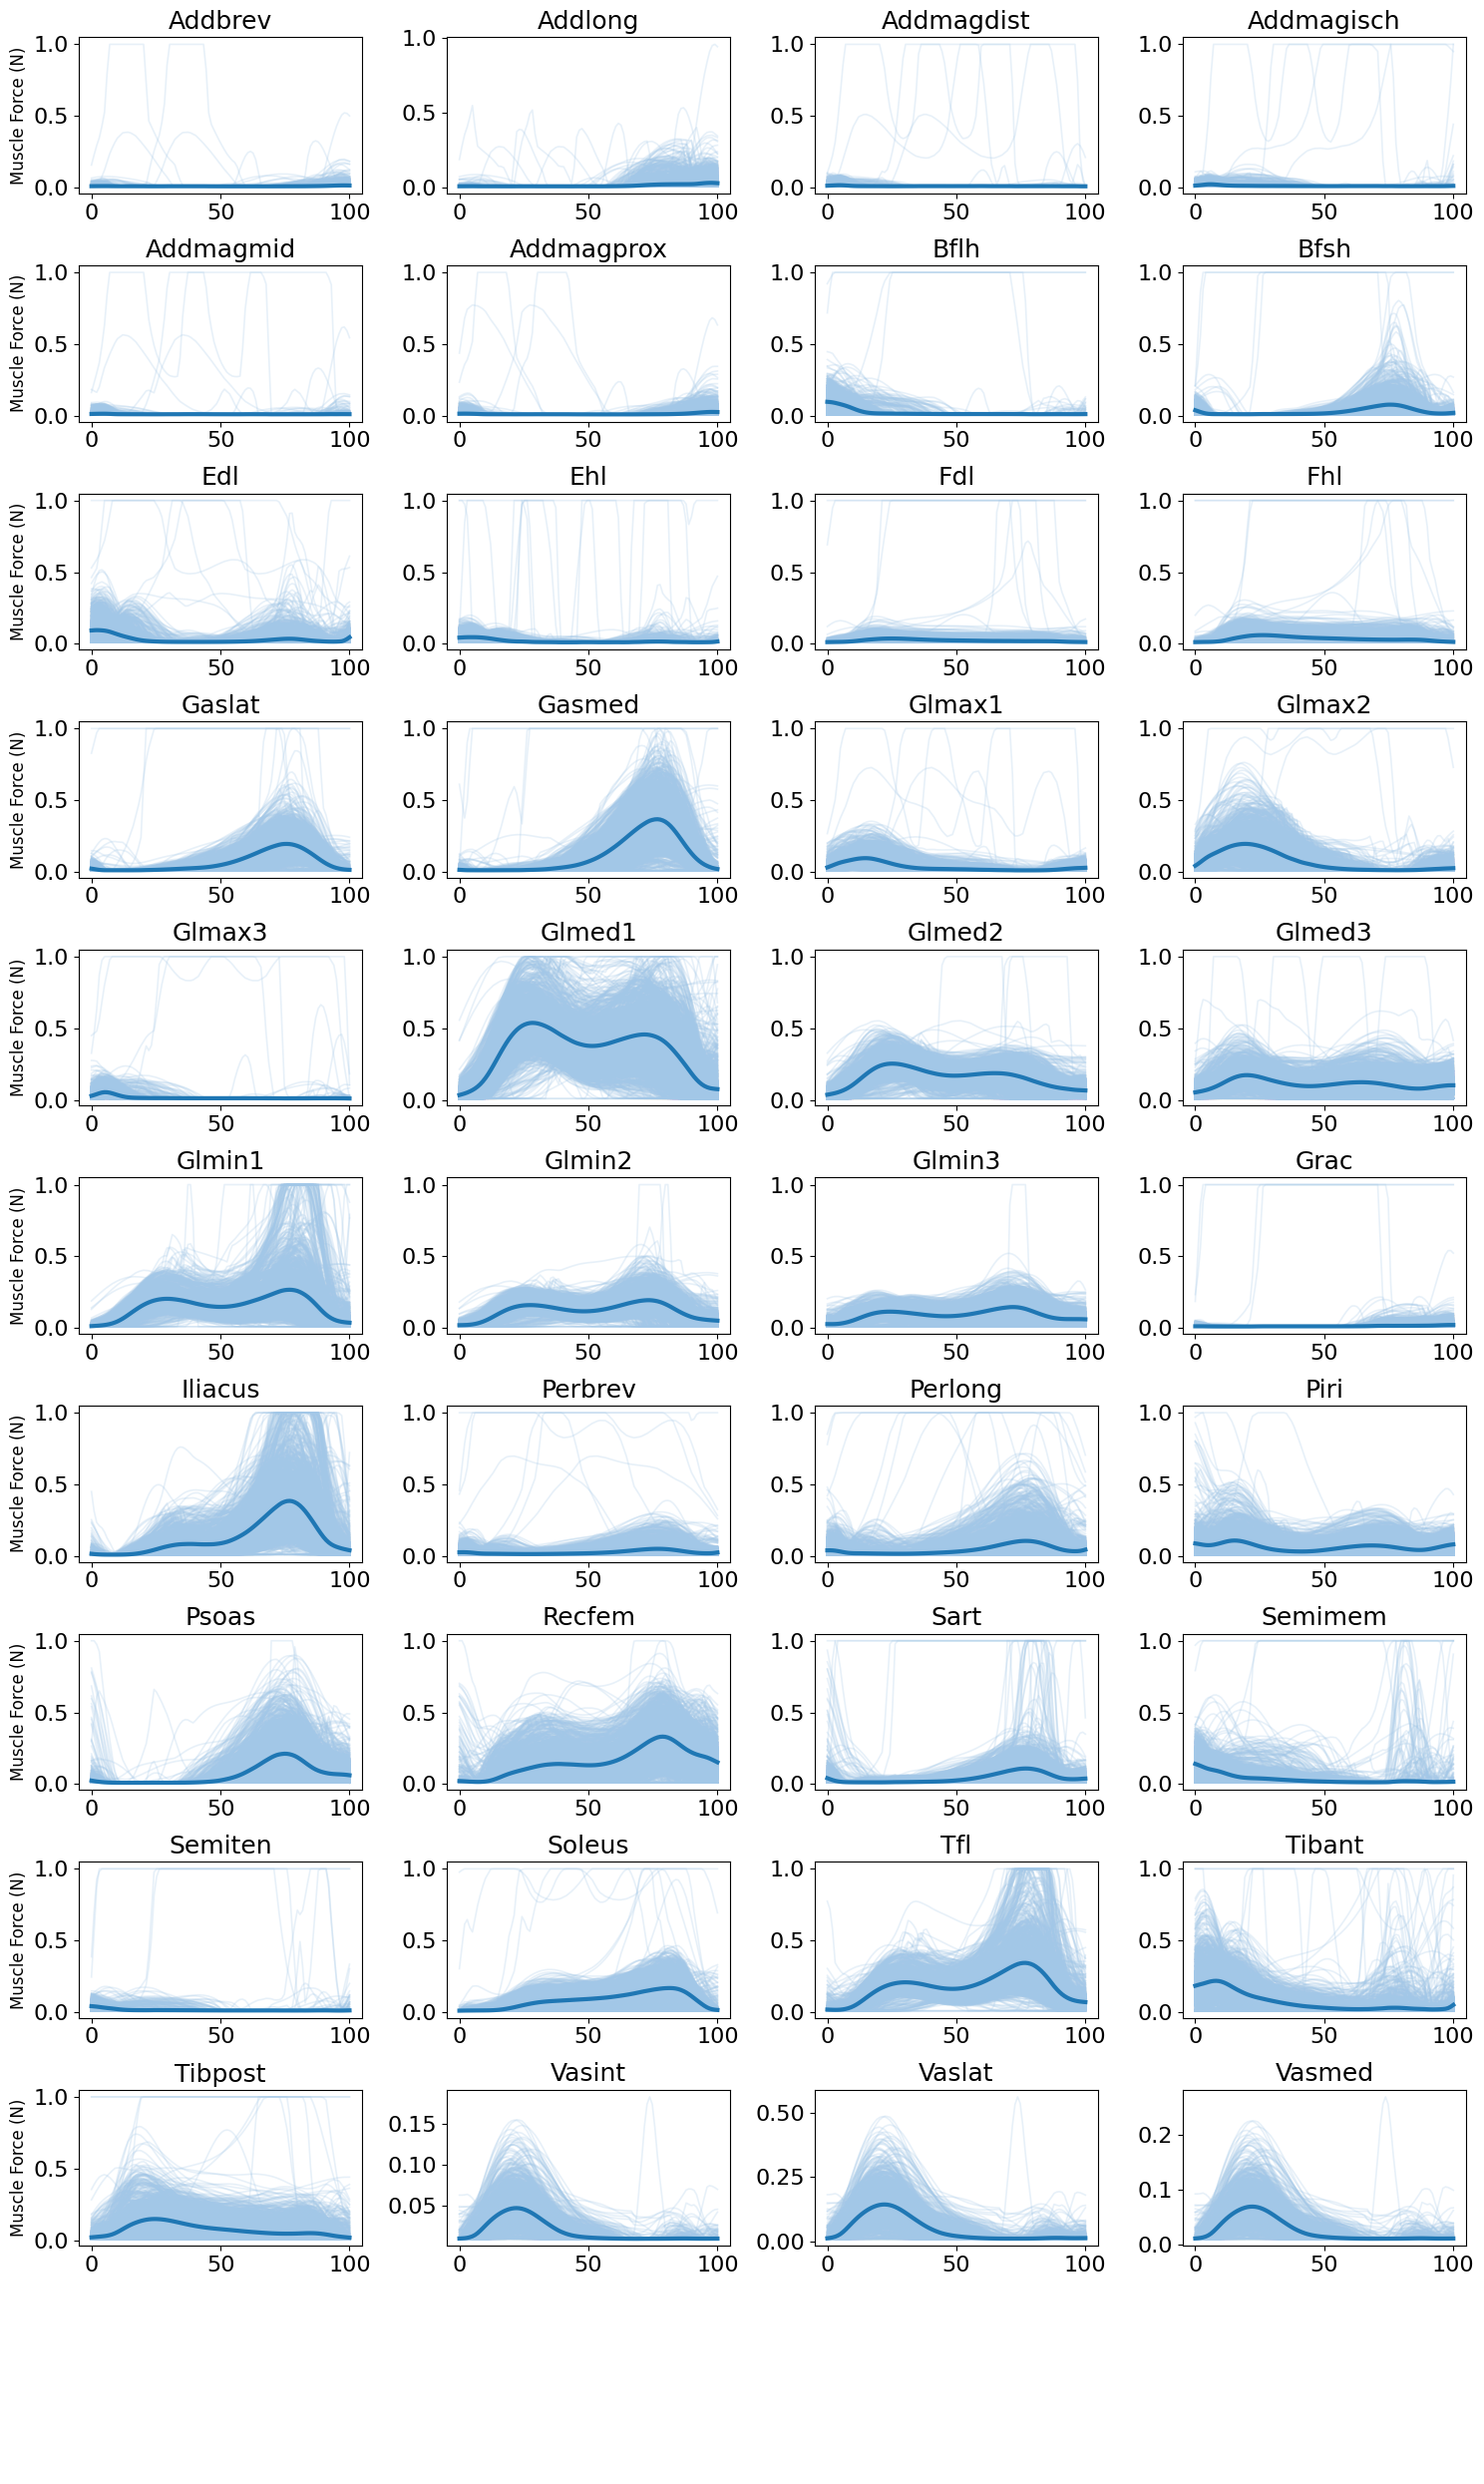

In [146]:
plot_muscle_grid(
    resampled_muscles=act_compiled,
    time_resampled=act_resampled["time_resampled"],
    muscle_keys=base_muscles,
    nrows=11,
    ncols=4,
    figsize=(15, 25),
    alpha=0.25,
    linewidth=1.2,
    plot_mean=True
)